<a href="https://colab.research.google.com/github/Howl06/practice/blob/main/01_brain_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K

#### Download data

In [5]:
import requests
file_id = "1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H"
file = requests.get('https://drive.google.com/uc?export=download&confirm=9_s_&id=' + file_id)
open('brain-mri-seg.zip', 'wb').write(file.content)

130498325

In [6]:
# download dataset from https://drive.google.com/file/d/1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H/view?usp=sharing
# !gdown --fuzzy 1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H --output brain-mri-seg.zip

In [7]:
# unzip file
!unzip -q brain-mri-seg.zip

#### Data Analysis

In [8]:
# read img and mask
mask_paths = glob('brain-mri-seg/train/*_mask.tif')
mask_path = np.random.choice(mask_paths, size=1)[0]
img_path = mask_path.replace('_mask', '')

print('img_path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

img_path:  brain-mri-seg/train/TCGA_FG_7637_20000922_24.tif
mask path: brain-mri-seg/train/TCGA_FG_7637_20000922_24_mask.tif


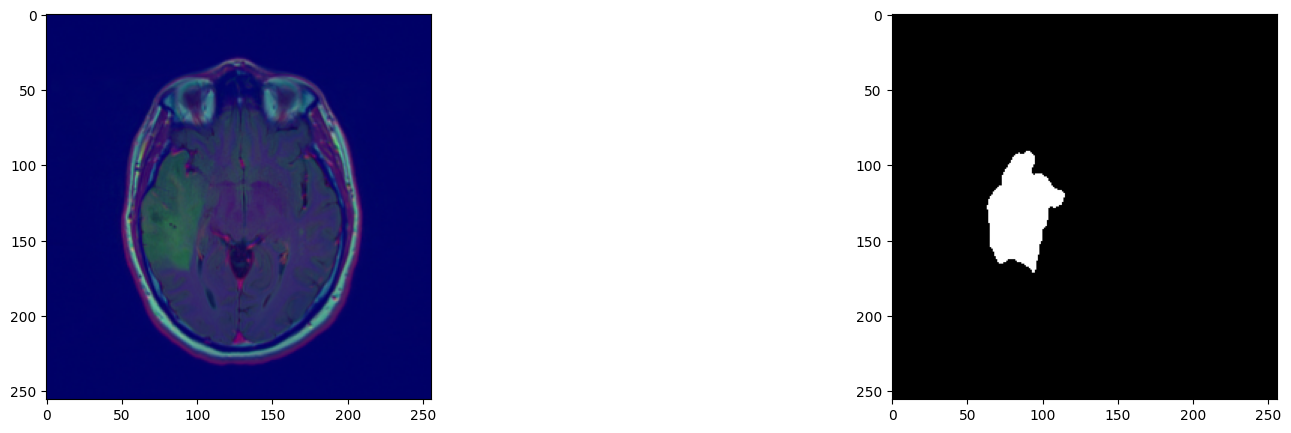

In [9]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

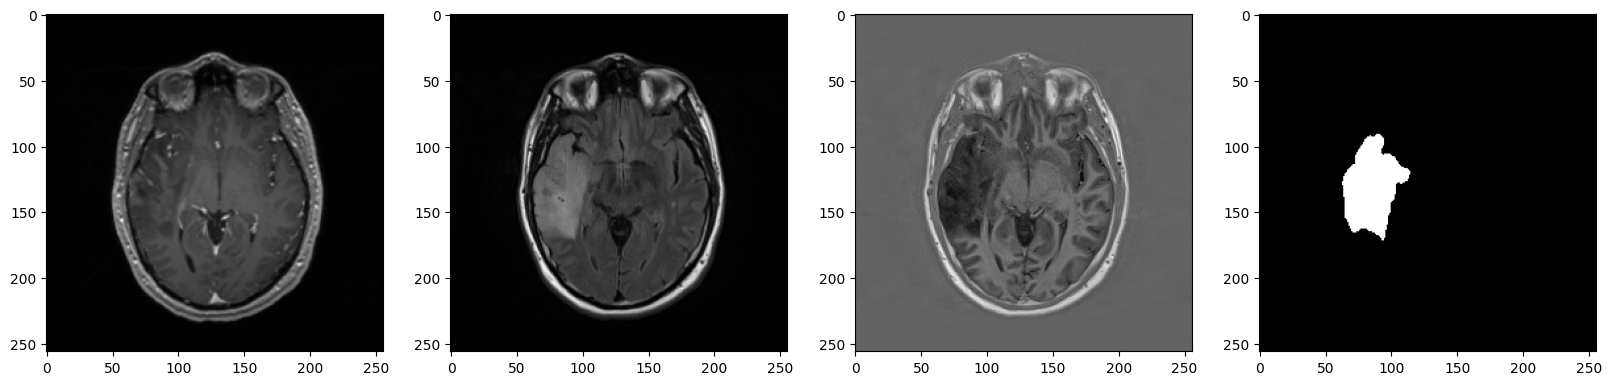

In [10]:
# show channelwise image 
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(img[:,:,i], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(mask)
plt.show()

In [11]:
img.shape, mask.shape

((256, 256, 3), (256, 256, 3))

#### Data processing

In [12]:
IMG_SIZE = 256 # 16x, 32x
BS = 32

In [13]:
class DataGenerator(utils.Sequence):
    def __init__(self, folder_path, batch_size, img_size, shuffle=True, aug=False):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                rotate=(-45, 45), # random rotate -45 ~ +45 degree
                shear=(-10, 10), # random shear degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])

        self.mask_paths = glob(os.path.join(folder_path, '*_mask.tif'))
        self.img_paths = [p.replace('_mask', '') for p in self.mask_paths]
        self.indexes = np.arange(len(self.mask_paths))
        # 執行一次shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path)
            # img and mask preprocess
            img = self.preprocess(img) # 0~255 -> 0~1
            mask = self.preprocess(mask) # 0, 255 -> 0 or 1
            x[i] = img
            y[i] = mask[:,:, :1] # 3 channels -> 1 channels
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y
    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [14]:
train_gen = DataGenerator('brain-mri-seg/train', BS, IMG_SIZE, aug=True)
test_gen = DataGenerator('brain-mri-seg/test', BS, IMG_SIZE, aug=False)

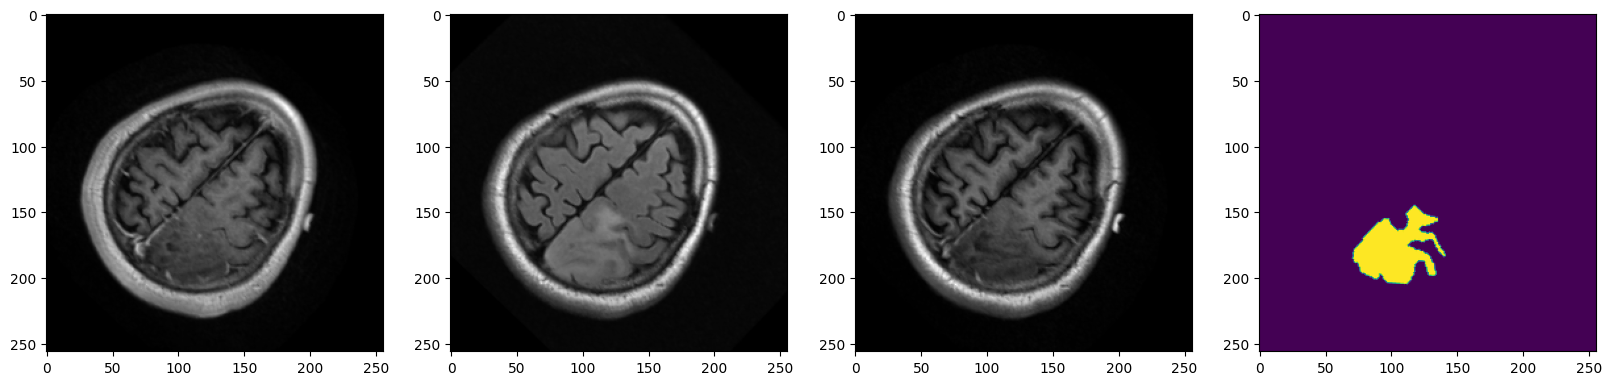

In [15]:
# Check training output

batch_x, batch_y = train_gen[0]

for batch_i in range(1):
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1,4,i+1)
        plt.imshow(batch_x[batch_i, :,:,i], cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(batch_y[batch_i, :,:, 0])
    plt.show()

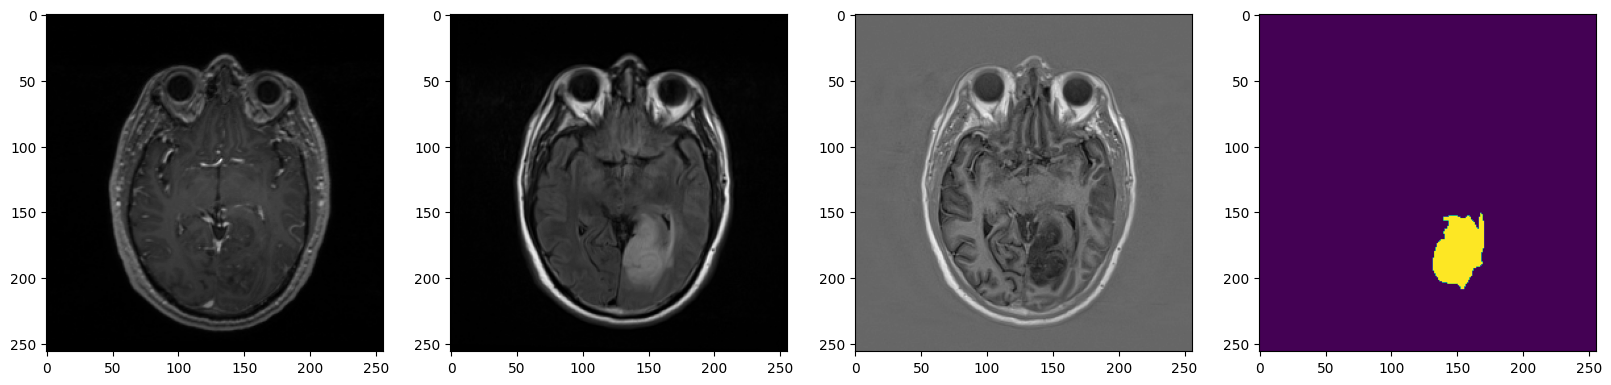

In [16]:
# Check output

batch_x, batch_y = test_gen[0]

for batch_i in range(1):
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1,4,i+1)
        plt.imshow(batch_x[batch_i, :,:,i], cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(batch_y[batch_i, :,:, 0])
    plt.show()

In [17]:
a = np.array([[[1,5],[2,6]],[[3,5],[4,5]]])
a.shape
a[0,:,0]

array([1, 2])

#### Build model UNet

> 縮排段落



In [ ]:
# Conv2DTranspose stride Finally, the kernel is moved across this intermediate grid in step sizes of 1. This step size is always 1. The stride option is used to set how far apart the original cells are in the intermediate grid. Unlike normal convolution, here the stride is not used to decide how the kernel moves.

In [18]:
# Method 1: Enlarge feature maps by UpSampling2D
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D()(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

# Decoder
l = layers.concatenate([layers.UpSampling2D()(c4), 
                        c3], axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D()(l), 
                        c2], axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D()(l), 
                        c1], axis=-1)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)

# Output
output_layer = layers.Conv2D(
              filters=1, 
              kernel_size=1, 
              activation='sigmoid')(l)
                                                         
model = models.Model(input_layer, output_layer)

In [35]:
# Method 2: Enlarge feature maps by Conv2DTranspose
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D()(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

# Decoder
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=3, 
                                               strides=2, padding='same', 
                                               activation='relu')(c4), 
                        c3], 
                       axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=3, 
                                               strides=2, padding='same', 
                                               activation='relu')(l), 
                        c2], 
                       axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=3, 
                                               strides=2, padding='same', activation='relu')(l), 
                        c1], 
                       axis=-1)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = models.Model(input_layer, output_layer)

In [23]:
# Method 3: Enlarge feature maps by Conv2DTranspose fix
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D()(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

# Decoder
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=2, 
                                               strides=2, padding='same', 
                                               activation='relu')(c4), 
                        c3], 
                       axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=2, 
                                               strides=2, padding='same', 
                                               activation='relu')(l), 
                        c2], 
                       axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.concatenate([layers.Conv2DTranspose(filters=32, kernel_size=2, 
                                               strides=2, padding='same', activation='relu')(l), 
                        c1], 
                       axis=-1)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = models.Model(input_layer, output_layer)

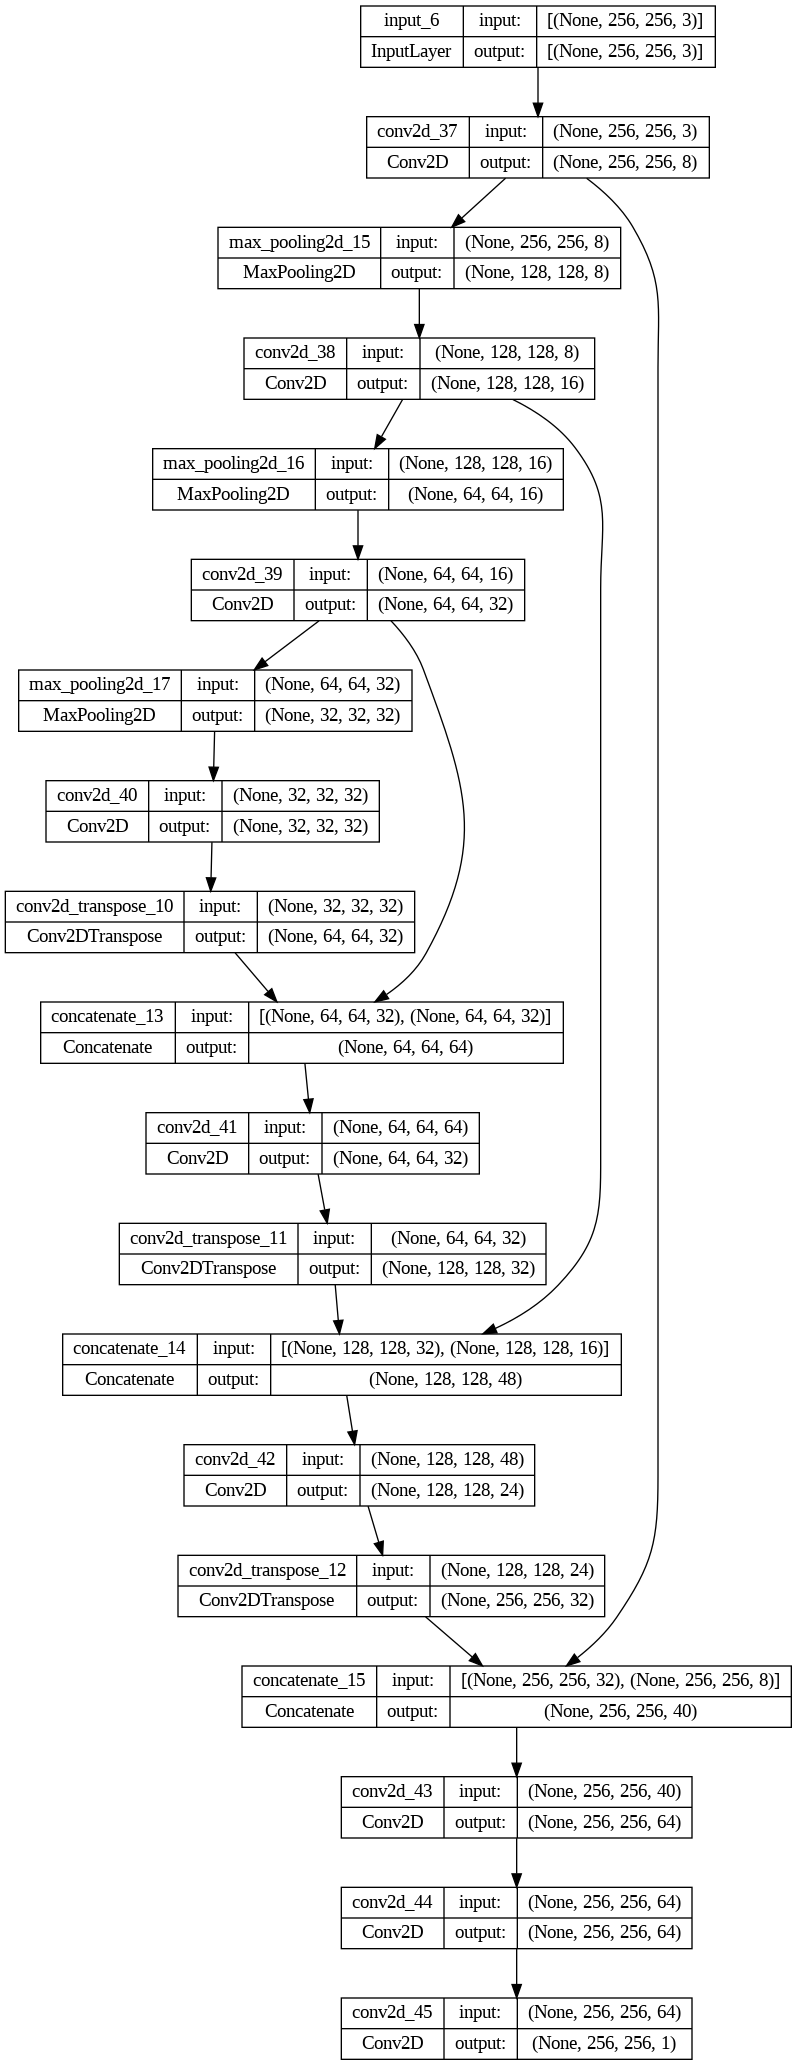

In [36]:
utils.plot_model(model, show_shapes=True)

#### Training

In [25]:
# Customize Metrics: Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Customize Dice Loss
def dice_loss(y_true, y_pred):
    dice = dice_coef(y_true, y_pred)
    return 1 - dice

In [26]:
model.compile(optimizer=optimizers.Adam(), 
              loss='binary_crossentropy', # keras.losses.BinaryCrossentropy()
            #   loss=dice_loss,
              metrics=[dice_coef])

In [27]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', 
                                         save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss', 
                                    patience=5)

In [28]:
logs = model.fit(train_gen,
                 validation_data = test_gen,
                 epochs=100,
                 callbacks = [weight_saver, earlystop])

Epoch 1/100
35/35 [==============================] - 37s 458ms/step - loss: 0.3131 - dice_coef: 0.0342 - val_loss: 0.1063 - val_dice_coef: 0.0830
Epoch 2/100
35/35 [==============================] - 11s 313ms/step - loss: 0.0755 - dice_coef: 0.2204 - val_loss: 0.0734 - val_dice_coef: 0.2959
Epoch 3/100
35/35 [==============================] - 12s 326ms/step - loss: 0.0639 - dice_coef: 0.3259 - val_loss: 0.0734 - val_dice_coef: 0.3206
Epoch 4/100
35/35 [==============================] - 11s 315ms/step - loss: 0.0610 - dice_coef: 0.3425 - val_loss: 0.0707 - val_dice_coef: 0.3393
Epoch 5/100
35/35 [==============================] - 11s 312ms/step - loss: 0.0606 - dice_coef: 0.3494 - val_loss: 0.0687 - val_dice_coef: 0.3524
Epoch 6/100
35/35 [==============================] - 11s 315ms/step - loss: 0.0593 - dice_coef: 0.3619 - val_loss: 0.0720 - val_dice_coef: 0.3558
Epoch 7/100
35/35 [==============================] - 11s 318ms/step - loss: 0.0580 - dice_coef: 0.3777 - val_loss: 0.0708 - 

#### Evaluate

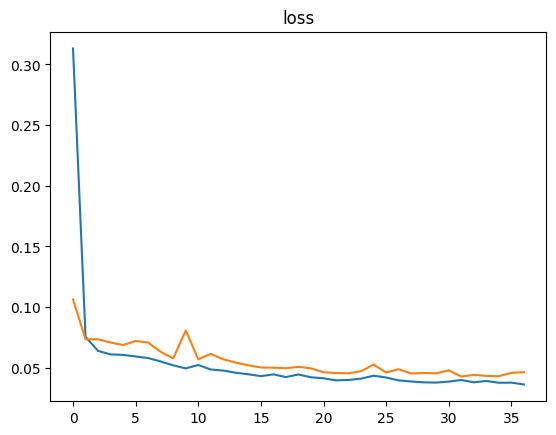

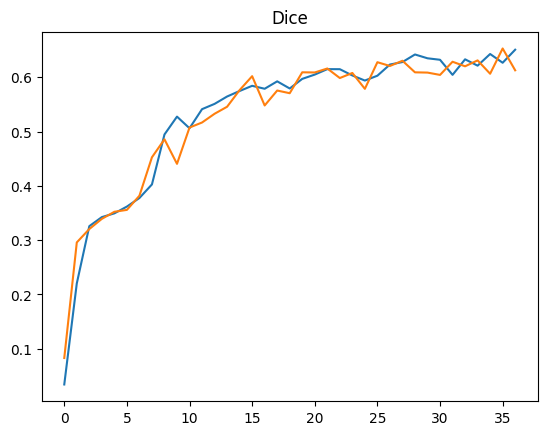

In [29]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()

In [31]:
model_final = models.load_model('seg.h5', compile=False)

3
1/1 [==============================] - 0s 309ms/step


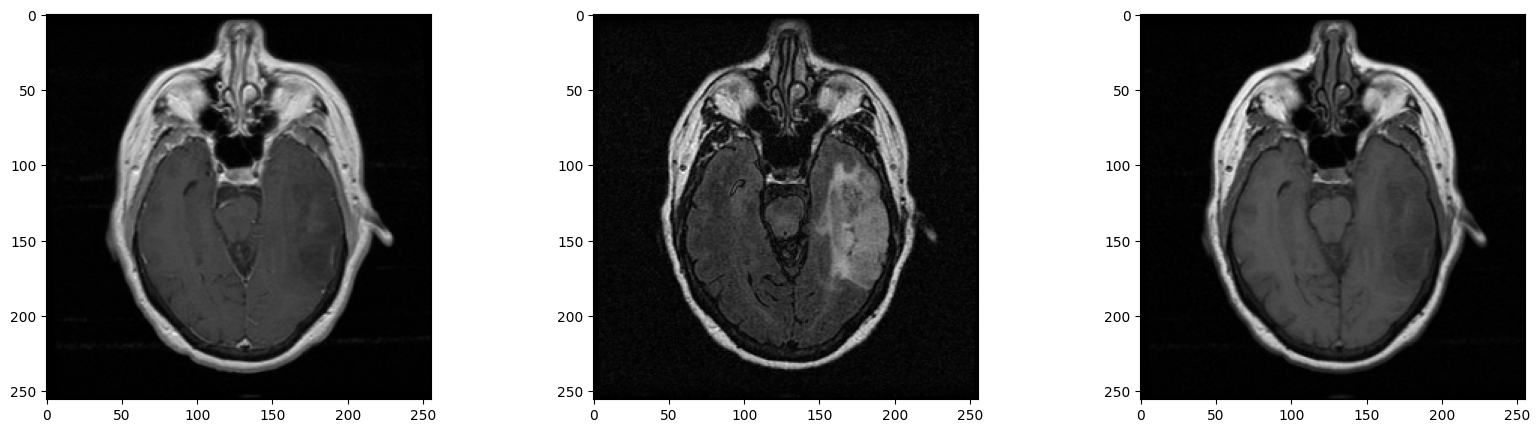

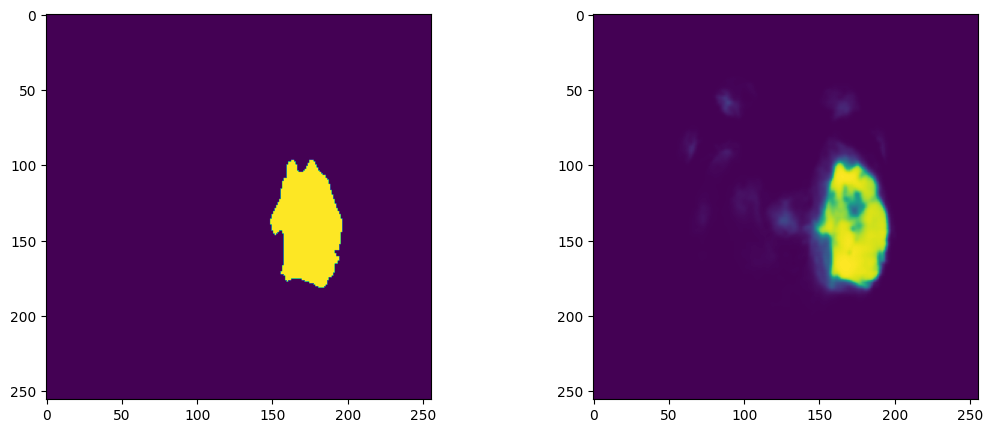

In [32]:
# Sample 1 batch
batch_idx = np.random.randint(len(test_gen))
print(batch_idx)
data = test_gen[batch_idx]
imgs, mask = data # (bs, 256, 256, 3), (bs, 256, 256, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(imgs[img_idx, :,:, i], cmap='gray')
plt.show()

# show ground truth & model prediction
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask[img_idx, :, :, 0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [33]:
# Displayed by different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[1.0766015e-06, 7.5413786e-11, 5.1003722e-13, ..., 2.2203825e-12,
        5.4512652e-09, 5.2830972e-05],
       [1.7719554e-09, 1.7309656e-15, 2.0970234e-18, ..., 8.7698557e-18,
        8.9307630e-13, 4.1810438e-07],
       [2.9642408e-10, 1.2716872e-16, 1.5820102e-19, ..., 1.3388096e-18,
        1.5621888e-13, 1.5808460e-07],
       ...,
       [1.1603983e-06, 8.5096527e-11, 2.7304816e-12, ..., 1.1498362e-08,
        6.8822334e-07, 1.6734656e-04],
       [2.2764539e-06, 1.7465271e-10, 2.9879597e-12, ..., 3.6308889e-09,
        2.8113766e-07, 9.6851276e-05],
       [3.3187639e-04, 1.0499355e-06, 6.6441167e-08, ..., 2.6706673e-06,
        5.0276787e-05, 2.1039464e-03]], dtype=float32)

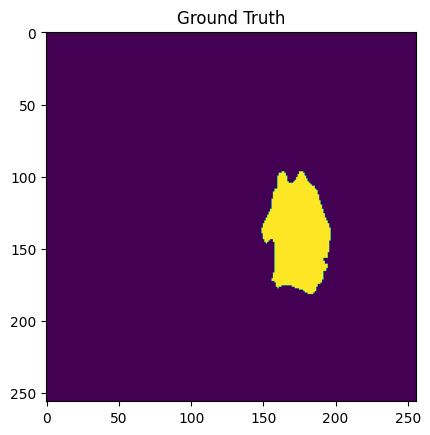

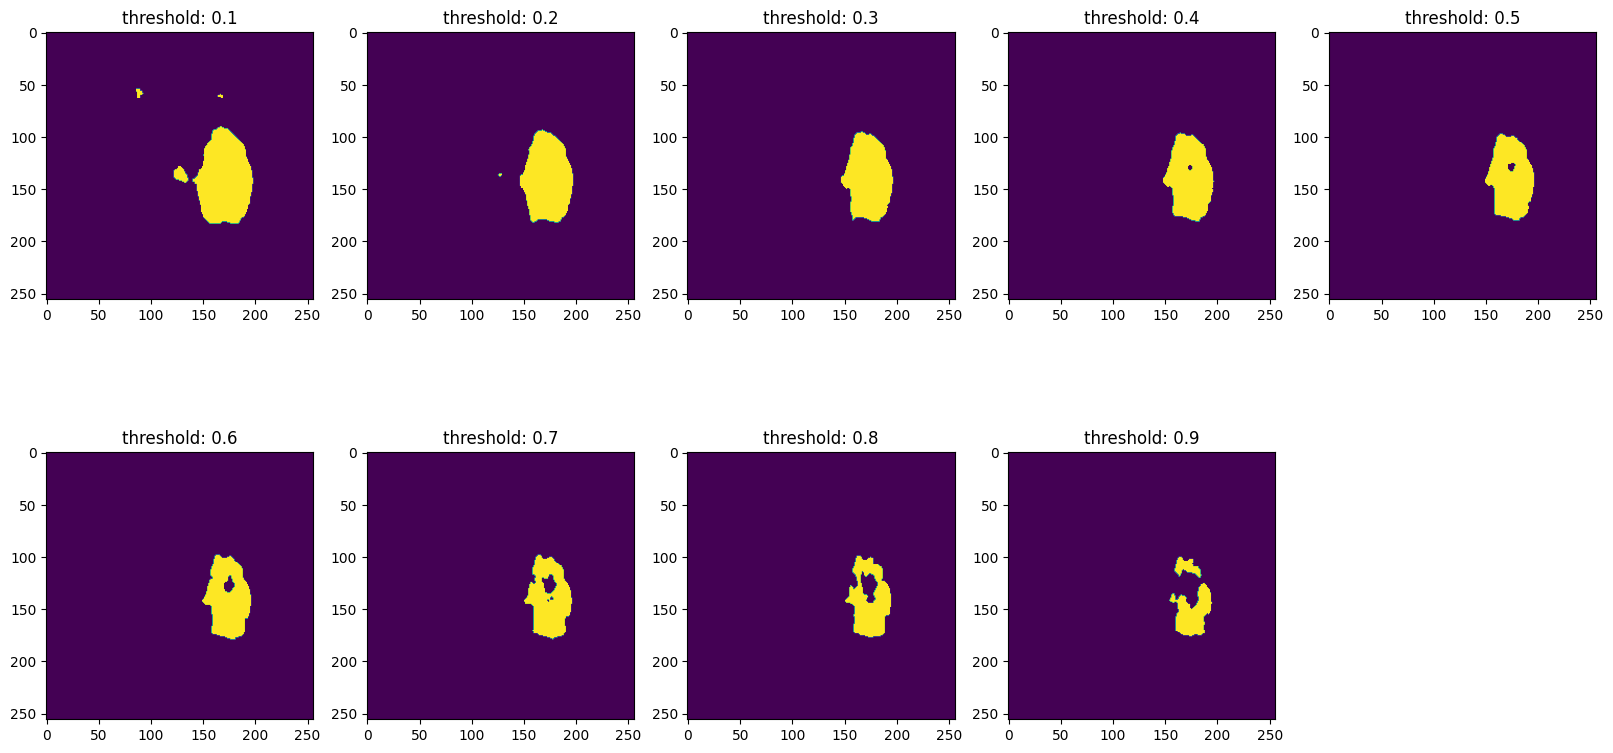

In [34]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()